In [3]:
import matplotlib.pyplot as plt
import numpy as np
import re
import json
import sys 
import os
import random



In [4]:
combined_tree_files = open('trees_for_clustering/combined/1st_paths.txt').readlines()

first_forest = []

for tree_file in combined_tree_files:
    first_forest.append(json.load(open(tree_file.strip())))

counts = np.loadtxt('../raw_data/counts.txt')
# header = np.loadtxt('./header_backup.npy')

In [5]:
# print first_forest[0]['feature']
# print first_forest[0]['split']
# print first_forest[0]['samples']
# print first_forest[0]['medians']
# print first_forest[0]['children'][0]['samples']



# for sample in [int(x) for x in first_forest[0]['children'][0]['samples']]:
#     print sample
#     print observed_counts[sample,1]

In [6]:
def numpy_mad(mtx):
    medians = []
    for column in mtx.T:
        medians.append(np.median(column[column!=0]))
    median_distances = np.abs(mtx - np.tile(np.array(medians), (mtx.shape[0],1)))
    mads = []
    for (i,column) in enumerate(median_distances.T):
        mads.append(np.median(column[mtx[:,i]!=0]))
    return np.array(mads)

(4773,)


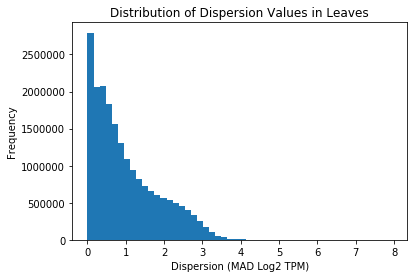

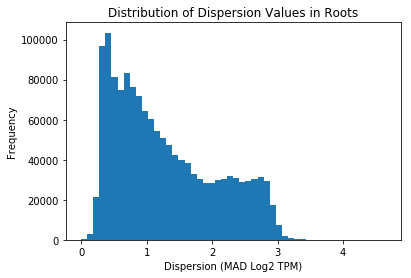

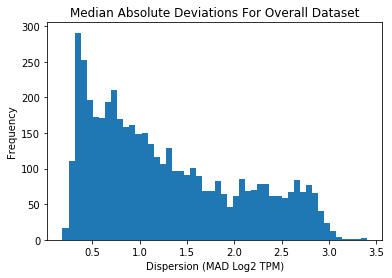

In [7]:
def tree_fit(tree):
    fits = []
    if len(tree['children']) > 0:
        for child in tree['children']:
            fits.extend(tree_fit(child))
    else:
        fits = list(zip(tree['features'],tree['dispersions']))
    return fits



def root_fit(tree):
    fits = zip(tree['features'],tree['dispersions'])
    return fits
           
leaf_fits = []

for tree in first_forest:
    leaf_fits.extend(tree_fit(tree))
           
plt.figure("overall_fit")
plt.title("Distribution of Dispersion Values in Leaves")
plt.xlabel("Dispersion (MAD Log2 TPM)")
plt.ylabel("Frequency")
plt.hist(map(lambda x: x[1],leaf_fits),bins=50)
plt.savefig("figures/leaf_quality.png")

root_fits = []

for tree in first_forest:
    root_fits.extend(root_fit(tree))

plt.figure("prior_to_fit")
plt.title("Distribution of Dispersion Values in Roots")
plt.xlabel("Dispersion (MAD Log2 TPM)")
plt.ylabel("Frequency")
plt.hist(map(lambda x: x[1],root_fits),bins=50)
plt.savefig("figures/root_quality.png")

    
    
print numpy_mad(counts).shape

plt.figure("overall_mads_unsorted")
plt.title("Median Absolute Deviations For Overall Dataset")
plt.xlabel("Dispersion (MAD Log2 TPM)")
plt.ylabel("Frequency")
plt.hist(numpy_mad(counts).flatten(), bins=50)
plt.savefig("figures/mads_raw_data.png")

[u'1142', u'2302', u'4446', u'1143', u'3928', u'164', u'4023', u'632', u'3711', u'2189', u'2172', u'1949', u'4305', u'3251', u'1941', u'1946', u'4140', u'4143', u'4142', u'2855', u'3857', u'1527', u'341', u'3997', u'3996', u'3995', u'814', u'1261', u'3991', u'2177', u'2859', u'2911', u'1799', u'1399', u'2916', u'1792', u'2836', u'330', u'713', u'966', u'2857', u'710', u'870', u'3331', u'1494', u'1265', u'1103', u'1498', u'3449', u'4189', u'1069', u'4570', u'916', u'348', u'4737', u'1707', u'2316', u'2077', u'4739', u'2312', u'2310', u'2311', u'1669', u'3682', u'297', u'292', u'1543', u'591', u'4328', u'592', u'198', u'1080', u'599', u'1121', u'4323', u'3778', u'4324', u'1126', u'2890', u'271', u'3678', u'3679', u'2828', u'3145', u'2824', u'3149', u'230', u'4555', u'2820', u'4658', u'3674', u'4551', u'3169', u'1106', u'3384', u'2547', u'3814', u'3029', u'3028', u'3027']


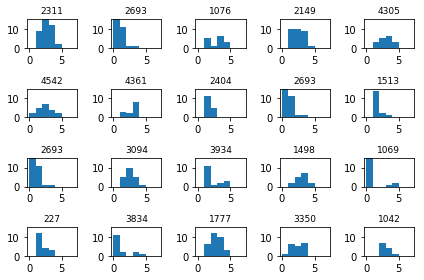

In [8]:
def feature_levels(tree,level):
    
#     print level
    
    features = {}

    feature = tree['feature']

#     print feature
    
    features[feature] = []
    features[feature].append(level)
    
    for child in tree['children']:

        child_features = feature_levels(child,level+1)

        for feature in child_features:

            if feature not in features:    
                features[feature] = []
            features[feature].extend(child_features[feature])

    return features
                
def forest_levels(trees):
    forest_feature_levels = {}
    for i,tree in enumerate(trees):
#         print i
        tree_feature_levels = feature_levels(tree,0)
        for feature in tree_feature_levels:
            if feature not in forest_feature_levels:
                forest_feature_levels[feature] = []
            forest_feature_levels[feature].extend(tree_feature_levels[feature])
    return forest_feature_levels

# print feature_levels(trees[0],0)

forest_feature_levels = forest_levels(first_forest)

print forest_feature_levels.keys()[:100]


plt.figure("feature_level_gigaplex")


for i in range(20):
    

    while True:
        feature = forest_feature_levels.keys()[random.randint(0,len(forest_feature_levels)-1)]

        if len(forest_feature_levels[feature]) > 10:

            plt.subplot(4,5,i+1)

            plt.title(feature,size=9)
            plt.ylim(0,15)
            plt.hist(forest_feature_levels[feature],bins=np.arange(8))
            
            break

plt.tight_layout()
plt.savefig("feature_level_gigaplex.png",dpi=300)


[(u'4696', u'0', 0.34005616135749545), (u'4696', u'1', 0.10252962451772296), (u'4696', u'2', 0.10473755522278111), (u'4696', u'3', 0.4312790618276159), (u'4696', u'4', 0.3243642062525392), (u'4696', u'5', 0.008545944422763185), (u'4696', u'6', 0.009638073193876773), (u'4696', u'7', 0.3511193840682124), (u'4696', u'8', 0.21433531431452113), (u'4696', u'9', 0.16687633209511835)]


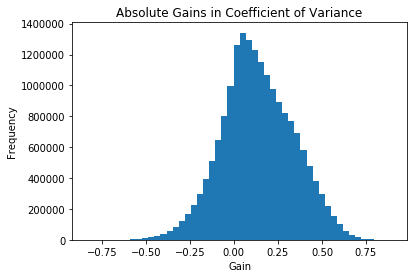

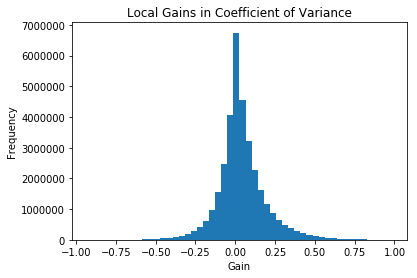

In [9]:
def leaf_gain_stats(tree):
    feature = tree['feature']
    feature_gain_pairs = []
    for child in tree['children']:
        feature_gain_pairs.extend(leaf_gain_stats(child))
    if len(feature_gain_pairs) == 0:
        for child in tree['children']:
            for gaining_feature,local_gain in zip(child['features'],child['absolute_gains']):
                feature_gain_pairs.append((feature,gaining_feature,local_gain))

    return feature_gain_pairs

def node_gain_stats(tree):
    feature = tree['feature']
    feature_gain_pairs = []
    for child in tree['children']:
        feature_gain_pairs.extend(node_gain_stats(child))
    for child in tree['children']:
        for gaining_feature,local_gain in zip(child['features'],child['local_gains']):
            feature_gain_pairs.append((feature,gaining_feature,local_gain))

    return feature_gain_pairs


def feature_gain_forest(trees):
    feature_gain_pairs = []
    for tree in trees:
        feature_gain_pairs.extend(leaf_gain_stats(tree))
    return feature_gain_pairs

def node_gain_forest(trees):
    feature_gain_pairs = []
    for tree in trees:
        feature_gain_pairs.extend(node_gain_stats(tree['children'][0]))
        feature_gain_pairs.extend(node_gain_stats(tree['children'][1]))
    return feature_gain_pairs

abs_gain_pairs = feature_gain_forest(first_forest)
node_gain_pairs = node_gain_forest(first_forest)

print abs_gain_pairs[:10]

plt.figure("gain_statistics")
plt.title("Absolute Gains in Coefficient of Variance")
plt.xlabel("Gain")
plt.ylabel("Frequency")
plt.hist(map(lambda x: x[2],abs_gain_pairs),bins=50)
plt.savefig("figures/abs_gains.png")

plt.figure("node_gain_statistics")
plt.title("Local Gains in Coefficient of Variance")
plt.xlabel("Gain")
plt.ylabel("Frequency")
plt.hist(map(lambda x: x[2],node_gain_pairs),bins=50)
plt.savefig("figures/loc_gains.png")

In [10]:
import scipy.special
from scipy.stats import linregress
from scipy.spatial.distance import jaccard
from scipy.spatial.distance import pdist

from sklearn.decomposition import KernelPCA
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.manifold import MDS

from hdbscan import HDBSCAN

from scipy.cluster import hierarchy as hrc
from sklearn.decomposition import PCA

from sklearn.cluster import AgglomerativeClustering

from sklearn.metrics import jaccard_similarity_score
jaccard_index = jaccard_similarity_score

import copy


In [11]:
def tree_to_nodes(tree,tree_id,requirements=None):
    
    tree = copy.copy(tree)
    
    nodes = []

    if requirements == None:
        requirements = []
    
    children = [x for x in tree['children']]
    tree['children'] = []
        
    tree['requirements'] = requirements
    tree['tree_id'] = tree_id
    
    nodes.append(tree)
    
    if len(children) > 0:
        nodes.extend([x for x in tree_to_nodes(children[0],tree_id,requirements + [tree['feature'],"<"])]) 
        nodes.extend([x for x in tree_to_nodes(children[1],tree_id,requirements + [tree['feature'],">"])])

    return nodes

def tree_to_nodes_x(tree,tree_id,limit=3,level=0,requirements=None):
    
    tree = copy.copy(tree)
    
    nodes = []

    if requirements == None:
        requirements = []
    
    children = [x for x in tree['children']]
    tree['children'] = []
        
    tree['requirements'] = requirements
    tree['tree_id'] = tree_id
    
    nodes.append(tree)
    
    if level >= limit:
        return nodes
    
    if len(children) > 0:
        nodes.extend([x for x in tree_to_nodes_x(children[0],tree_id,limit,level+1,requirements + [tree['feature'],"<"])]) 
        nodes.extend([x for x in tree_to_nodes_x(children[1],tree_id,limit,level+1,requirements + [tree['feature'],">"])])

    return nodes


def tree_to_leaves(tree,tree_id,requirements=None):
    
    nodes = []

    if requirements == None:
        requirements = []
    
    children = [x for x in tree['children']]
        
    tree['requirements'] = requirements
    tree['tree_id'] = tree_id
    
    if len(children) == 0:
        nodes.append(tree)
    
    if len(children) > 0:
        nodes.extend([x for x in tree_to_leaves(children[0],tree_id,requirements + [tree['feature'],"<"])]) 
        nodes.extend([x for x in tree_to_leaves(children[1],tree_id,requirements + [tree['feature'],">"])])

    return nodes

def tree_to_leaves_m1(tree,tree_id,requirements=None):
    
    nodes = []

    if requirements == None:
        requirements = []
    
    children = []

    for child in tree['children']:
        if len(child['children']) > 0:
            children.append(child)

    tree['requirements'] = requirements
    tree['tree_id'] = tree_id
    
    if len(children) == 0:
        nodes.append(tree)
    
    if len(children) > 0:
        try:
            nodes.extend([x for x in tree_to_leaves_m1(children[0],tree_id,requirements + [tree['feature'],"<"])]) 
        except:
            pass
        try:
            nodes.extend([x for x in tree_to_leaves_m1(children[1],tree_id,requirements + [tree['feature'],">"])])
        except:
            pass
    
    return nodes

def tree_to_leaves_x(tree,tree_id,limit=3,level=0,requirements=None):
    
    nodes = []

    if requirements == None:
        requirements = []
    
    children = [x for x in tree['children']]
        
    tree['requirements'] = requirements
    tree['tree_id'] = tree_id
    
    if level >= limit:
        nodes.append(tree)
        return nodes
    
    if len(children) == 0:
        nodes.append(tree)
    
    if len(children) > 0:
        nodes.extend([x for x in tree_to_leaves_x(children[0],tree_id,limit,level+1,requirements + [tree['feature'],"<"])]) 
        nodes.extend([x for x in tree_to_leaves_x(children[1],tree_id,limit,level+1,requirements + [tree['feature'],">"])])

    return nodes

def forest_to_nodes(trees):
    nodes = []
    for tree in trees:
        nodes.extend([x for x in tree_to_nodes(tree['children'][0],i)])
        nodes.extend([x for x in tree_to_nodes(tree['children'][1],i)])
    
    return nodes

def forest_to_nodes_x(trees,lim):
    nodes = []
    for tree in trees:
        nodes.extend([x for x in tree_to_nodes_x(tree['children'][0],i,lim)])
        nodes.extend([x for x in tree_to_nodes_x(tree['children'][1],i,lim)])
    
    return nodes

def forest_to_leaves(trees):
    nodes = []
    for i,tree in enumerate(trees):
        nodes.extend([x for x in tree_to_leaves(tree,i)])
    
    return nodes
    
def forest_to_leaves_m1(trees):
    nodes = []
    for tree in trees:
        nodes.extend([x for x in tree_to_leaves_m1(tree,i)])
    
    return nodes

def forest_to_leaves_x(trees,lim):
    nodes = []
    for tree in trees:
        nodes.extend([x for x in tree_to_leaves_x(tree,i,limit=lim)])
    
    return nodes
    
# def index_binary_encoding(samples, total_samples):
#     encoding = np.zeros(total_samples, dtype=bool)
#     for sample in samples:
#         encoding[int(sample)] = True
#     return encoding

def node_sample_encoding(nodes):
    
    samples = {}
    
    nested_samples = []
    
    for node in nodes:
        node_samples = []
        for sample in node['samples']:
            if sample not in samples:
                samples[sample] = len(samples)
            node_samples.append(samples[sample])
        nested_samples.append(node_samples)
    
    encoding = np.zeros((len(nodes),len(samples)),dtype=bool)

    for i, node_samples in enumerate(nested_samples):
        for j,sample in enumerate(node_samples):
            encoding[i][sample] = True
    
    return encoding

def alt_node_sample_encoding(nodes):
    
    samples = set()
    
    nested_samples = []
    
    for node in nodes:
        node_samples = []
        for sample in node['samples']:
            samples.add(sample)
            node_samples.append(sample)
        nested_samples.append(node_samples)
    
    encoding = np.zeros((len(nodes),max([int(x) for x in samples])+1),dtype=bool)

    for i, node_samples in enumerate(nested_samples):
        for j,sample in enumerate(node_samples):
            encoding[i][int(sample)] = True
    
    return encoding


def node_sample_pca(nodes):

    node_encoding = node_sample_encoding(nodes)

    embedding_model = PCA(n_components=2)

    coordinates = embedding_model.fit_transform(node_encoding)

    return coordinates

def node_sample_kpca(nodes):

    node_encoding = node_sample_encoding(nodes)

    embedding_model = KernelPCA(n_components=2,kernel='cosine')

    coordinates = embedding_model.fit_transform(node_encoding)

    return coordinates

def node_sample_tsne(nodes):

    node_encoding = alt_node_sample_encoding(nodes)

    pre_computed_distance = scipy.spatial.distance.squareform(pdist(node_encoding,metric='jaccard'))

    embedding_model = TSNE(n_components=2,metric='precomputed')

    coordinates = embedding_model.fit_transform(pre_computed_distance)

    return coordinates

def node_sample_mds(nodes):
    
    node_encoding = alt_node_sample_encoding(nodes)
    
    pre_computed_distance = pdist(node_encoding,metric='jaccard')

    embedding_model = MDS(n_components=2,dissimilarity='precomputed')

    coordinates = embedding_model.fit_transform(scipy.spatial.distance.squareform(pre_computed_distance))

    return coordinates

def node_sample_hdbscan(nodes):

    node_encoding = alt_node_sample_encoding(nodes)

    pre_computed_distance = pdist(node_encoding,metric='jaccard')

    clustering_model = HDBSCAN(min_samples=3,eps=.75, metric='precomputed')
    
    plt.figure()
    plt.title("Dbscan observed distances")
    plt.hist(pre_computed_distance,bins=50)
    plt.show()
    
    clusters = clustering_model.fit_predict(scipy.spatial.distance.squareform(pre_computed_distance))

#     clusters = clustering_model.fit_predict(node_encoding)

    return clusters


In [ ]:
from scipy.stats import pearsonr

def node_to_naive_counts(node,counts,header):

    sample_indecies = [int(x) for x in node['samples']]
    feature_indecies = [int(x) for x in node['features']]

    #     feature_indecies = [header.index(x) for x in node['features']]
    
    node_counts = counts[sample_indecies].T[feature_indecies].T
    
    return node_counts
    

def node_to_singly_sorted_counts(node,counts,header):
    
    sample_indecies = [int(x) for x in node['samples']]
    
    node_counts = counts[sample_indecies]
    
    split_feature = node['feature']

    split_feature_node_index = node['features'].index(split_feature)
    
    node_sample_split_sort = np.argsort(node_counts[:,split_feature_node_index])
    
    singly_sorted_node_counts = node_counts[node_sample_split_sort]
    
    split_sample_index = np.sum(node_counts[:,split_feature_node_index] < float(node['split']))
    
    return singly_sorted_node_counts, split_sample_index

    
def node_to_doubly_sorted_counts(node,counts,header):
    
    sample_indecies = [int(x) for x in node['samples']]
    feature_indecies = [int(x) for x in node['features']]
    #     feature_indecies = [header.index(x) for x in node['features']]
    
    node_counts = counts[sample_indecies].T[feature_indecies].T
    
    split_feature = node['feature']
    split_feature_node_index = node['features'].index(split_feature)
    
    node_sample_split_sort = np.argsort(node_counts[:,split_feature_node_index])
    
    singly_sorted_node_counts = node_counts[node_sample_split_sort]
    
    node_split_feature_correlations = np.array([pearsonr(node_counts[:,split_feature_node_index],x)[0] for x in node_counts.T])
    
    node_feature_split_sort = np.argsort(node_split_feature_correlations)
    
    doubly_sorted_node_counts = singly_sorted_node_counts.T[node_feature_split_sort].T
    
    split_sample_index = np.sum(node_counts[:,split_feature_node_index] < float(node['split']))
    
    return doubly_sorted_node_counts, split_sample_index


header = list(np.load('header_backup.npy'))

heat_map = node_to_naive_counts(first_forest[0],counts,header)

plt.figure("no_split")
im = plt.imshow(heat_map)
plt.colorbar(im,fraction=.008)
plt.savefig('figures/tree_movie/0.png',dpi=500)

split_map, split = node_to_doubly_sorted_counts(first_forest[0],counts,header)

plt.figure("one_split")
im = plt.imshow(split_map)
plt.plot([0,split_map.shape[1]-1],[split,split],c='xkcd:cyan',linewidth=.5)
plt.savefig('figures/tree_movie/1.png',dpi=500)

def cascading_node_slices_x(node,counts,header,depth=0):

    leaves = tree_to_leaves_x(node,0,depth)
    total_samples = 0
    splits = []

    print "Cascading"
    print len(leaves)
    
    total_counts = np.zeros((0,len(node['features'])))

    for leaf in leaves:
        if len(leaf['children']) > 0:
            node_counts, split_index = node_to_singly_sorted_counts(leaf,counts,header)
            splits.append(total_samples + split_index)
        else:
            node_counts = node_to_naive_counts(leaf,counts,header)
        total_samples += node_counts.shape[0]
        total_counts = np.concatenate((total_counts,node_counts), axis=0)
    
    return total_counts, splits


    
def make_tree_movie(node,counts,header,feature_sort,title,max_depth=1):

    splits = []
    
    for i in range(max_depth):
        
        split_map, new_splits = cascading_node_slices_x(node,counts,header,depth=i)

        plt.figure(figsize=(8,4))
        im = plt.imshow(split_map.T[feature_sort].T,aspect='auto')
        for split in splits:
            plt.plot([0,split_map.shape[1]-1],[split,split],c='xkcd:cyan',linewidth=.25)
        for split in new_splits:
            plt.plot([0,split_map.shape[1]-1],[split,split],c='blue',linewidth=.25)
        splits.extend(new_splits)
        plt.savefig('figures/tree_movie/%s.png' % (title + "." + str(i)),dpi=500)

           
node_counts = node_to_naive_counts(first_forest[0],counts,header)

gene_linked = hrc.linkage(node_counts.T, method='average', metric='correlation')
gene_dendrogram = hrc.dendrogram(gene_linked,no_plot=True)

make_tree_movie(first_forest[0],counts,header,gene_dendrogram['leaves'],"tree1",max_depth=5)

Cascading
1
Cascading
2


In [28]:
print len([x for y in tree_to_leaves(first_forest[0],0,) for x in y['samples']])

# combined_2nd_tree_files = open('trees_for_clustering/combined/2nd_paths.txt').readlines()

# second_layer = []

# for tree_file in combined_2nd_tree_files:
#     second_layer.append(json.load(open(tree_file.strip())))


326


In [ ]:
first_forest_leaves = forest_to_leaves(first_forest)
# second_forest_leaves = forest_to_leaves(second_layer)

print len(first_forest_leaves)
# print len(second_forest_leaves)

# print [len(x['features']) for x in first_forest_leaves]

# print list(alt_node_sample_encoding(first_forest_leaves)[0])
# print list(first_forest_leaves[0]['samples'])

# print np.sum(alt_node_sample_encoding(first_forest_leaves)[0])
# print len(first_forest_leaves[0]['samples'])

# for sample in first_forest_leaves[0]['samples']:
#     print alt_node_sample_encoding(first_forest_leaves)[0][int(sample)]


# print len(first_forest_leaves[0]['samples'])

ff_sample_coordinates = node_sample_mds(first_forest_leaves)
# sf_sample_coordinates = node_sample_mds(second_forest_leaves)

ff_sample_feature_cross_clusters = node_sample_hdbscan(first_forest_leaves)
# fs_sample_feature_cross_clusters = node_feature_dbscan(second_forest_leaves)

# print ff_sample_coordinates.shape
# print sf_sample_coordinates.shape

plt.figure("first_forest_sample_pca")
plt.title("First Layer Forest Node Sample Membership")
plt.scatter(ff_sample_coordinates[:,0],ff_sample_coordinates[:,1],s=.03,c=ff_sample_feature_cross_clusters,cmap="rainbow")
plt.savefig("figures/ff_sample_scatter.png", dpi=300)

# plt.figure("second_forest_sample_pca")
# plt.title("Second Layer Forest Node Sample Membership")
# plt.scatter(sf_sample_coordinates[:,0],sf_sample_coordinates[:,1],s=.03,c=fs_sample_feature_cross_clusters)
# plt.show()



In [ ]:
# impute_error = np.loadtxt('trees_for_clustering/combined/impute_error.txt')

In [ ]:
# plt.figure()
# plt.hist([np.sum(clusters == cluster) for cluster in set(list(clusters))],bins=50,log=True)
# plt.show()

In [ ]:
# plt.figure("embedded_nodes")
# plt.scatter(coordinates[:,0],coordinates[:,1],s=.03,c=clusters,cmap='rainbow')
# plt.savefig("node_clusters.png",dpi=500)

In [ ]:
# clst = coordinates[:,0] > 18

In [ ]:
# print sum(clst)

In [ ]:
# clst_indecies = np.arange(len(forest_nodes))[clst]
# clst_nodes = []

# for ind in clst_indecies:
#     clst_nodes.append(forest_nodes[ind])

# requirements = [x['requirements'] for x in clst_nodes]



In [ ]:
# [len(x['samples']) for x in clst_nodes]

In [ ]:
# plt.figure()
# plt.hist([x[0] for y in x for x in requirements])
# plt.show()

In [ ]:
# import seaborn as sns

In [ ]:
# large_cluster_requirements = [forest_nodes[x]['requirements'] for x in clusters == 0]

# print large_cluster_requirements[:300]
# plt.figure()
# plt.hist([x[0] for x in large_cluster_requirements if len(x) > 0])
# plt.show()

In [ ]:
# print [x['requirements'] for x in first_forest][:5]

In [ ]:
def extract_absolute_gain_vectors(nodes):
    
    features = {}
    
    gain_pairs = []
    
    for node in nodes:
        node_gain_pairs = []
        try:
            for feature,gain in zip(node['features'],node['absolute_gains']):
                if feature not in features:
                    features[feature] = len(features)
                node_gain_pairs.append((features[feature],gain))
            gain_pairs.append(node_gain_pairs)
        except:
            continue
    
    gain_matrix = np.zeros((len(nodes),len(features)))
    
    for n_ind,node_gain_pairs in enumerate(gain_pairs):
        for f_ind,gain in node_gain_pairs:
            gain_matrix[n_ind,f_ind] = gain
    
    features = [(x,features[x]) for x in features.keys()]
    
    features = sorted(features,key=lambda x: x[1])
    
    return gain_matrix, features

def extract_local_gain_vectors(nodes):
    
    features = {}
    
    gain_pairs = []
    
    for node in nodes:
        node_gain_pairs = []
        try:
            for feature,gain in zip(node['features'],node['local_gains']):
                if feature not in features:
                    features[feature] = len(features)
                node_gain_pairs.append((features[feature],gain))
            gain_pairs.append(node_gain_pairs)
        except:
            continue
    
    gain_matrix = np.zeros((len(nodes),len(features)))
    
    for n_ind,node_gain_pairs in enumerate(gain_pairs):
        for f_ind,gain in node_gain_pairs:
            gain_matrix[n_ind,f_ind] = gain
    
    return gain_matrix


def node_feature_pca(nodes):

    node_encoding,feature_header = extract_absolute_gain_vectors(nodes)

    embedding_model = PCA(n_components=2)

    coordinates = embedding_model.fit_transform(node_encoding)

    return coordinates



def node_feature_kpca(nodes):

    node_encoding,feature_header = extract_absolute_gain_vectors(nodes)

    embedding_model = KernelPCA(n_components=2,kernel='correlation')

    coordinates = embedding_model.fit_transform(node_encoding)

    return coordinates

def node_feature_tsne(nodes):

    node_encoding,feature_header = extract_absolute_gain_vectors(nodes)

#     embedding_model = TSNE(n_components=2,early_exaggeration=3,learning_rate=5,metric='correlation')

    embedding_model = TSNE(n_components=2, metric='cosine')


    coordinates = embedding_model.fit_transform(node_encoding)

    return coordinates

def node_feature_mds(nodes):
    
    node_encoding,feature_header = extract_absolute_gain_vectors(nodes)
    
    embedding_model = MDS(n_components=2,dissimilarity='precomputed')
        
    distances = scipy.spatial.distance.squareform(pdist(node_encoding,metric='correlation'))
    
    coordinates = embedding_model.fit_transform(distances)
    
    return coordinates

def node_feature_dbscan(nodes):

    node_encoding,feature_header = extract_absolute_gain_vectors(nodes)

    distances = scipy.spatial.distance.squareform(pdist(node_encoding,metric='cosine'))

    clustering_model = DBSCAN(min_samples=10, eps = .35, metric='precomputed')
    
    clusters = clustering_model.fit_predict(distances)
    
    plt.figure()
    plt.title("Dbscan observed distances")
    plt.hist(distances.flatten(),bins=50)
    plt.show()
    
    return clusters


In [ ]:
first_forest_leaves = forest_to_leaves(first_forest)
# second_forest_leaves = forest_to_leaves(second_layer)

ff_feature_coordinates = node_feature_tsne(first_forest_leaves)

ff_feature_clusters = node_feature_dbscan(first_forest_leaves)

# fs_feature_coordinates = node_feature_mds(second_forest_leaves)

# fs_feature_clusters = node_feature_dbscan(second_forest_leaves)

plt.figure("first_forest_feature_pca")
plt.title("First Layer Forest Leaf Feature Gain")
plt.scatter(ff_feature_coordinates[:,0],ff_feature_coordinates[:,1],s=.03,c=ff_feature_clusters,cmap='rainbow')
plt.savefig("figures/ff_feature_tsne_dbscan_color.png",dpi=500)

# plt.figure("second_forest_feature_pca")
# plt.title("Second Layer Forest Node Feature Gain")
# plt.scatter(fs_feature_coordinates[:,0],fs_feature_coordinates[:,1],s=.03,c=fs_feature_clusters,cmap='rainbow')
# plt.savefig("figures/fs_feature_tsne_dbscan_color.png",dpi=300)


In [ ]:
# print len(set(list(fs_feature_clusters)))

In [ ]:
# dist = pdist(extract_local_gain_vectors(forest_to_nodes(first_forest)),metric='cityblock')
# print dist.shape
# print dist[:10]
# print np.sum(np.isnan(dist))
# plt.figure("cos_dist_dist")
# plt.hist(dist,bins=50)
# plt.show()

In [ ]:
# first_forest_nodes = forest_to_nodes(first_forest)
# # second_forest_nodes = forest_to_nodes(second_layer)

# ff_feature_vectors = extract_local_gain_vectors(first_forest_nodes)

# embedding_model = TSNE(n_components=2,metric='cosine',learning_rate=100,perplexity=50)
# ff_local_feature_coordinates = embedding_model.fit_transform(ff_feature_vectors)

# clustering_model = DBSCAN(eps=50,min_samples=2,metric='cityblock')
# ff_local_feature_clusters = clustering_model.fit_predict(ff_feature_vectors)

# plt.figure("first_forest_feature_pca")
# plt.title("First Layer Forest Node Feature Gain")
# plt.scatter(ff_local_feature_coordinates[:,0],ff_local_feature_coordinates[:,1],s=.03,c=ff_local_feature_clusters,cmap='rainbow')
# plt.savefig("figures/ff_feature_tsne_dbscan_color.png",dpi=500)

# plt.figure("second_forest_feature_pca")
# plt.title("Second Layer Forest Node Feature Gain")
# plt.scatter(fs_feature_coordinates[:,0],fs_feature_coordinates[:,1],s=.03,c=fs_feature_clusters,cmap='rainbow')
# plt.savefig("figures/fs_feature_tsne_dbscan_color.png",dpi=300)

In [ ]:
def cluster_stats(nodes):
    
    split_features = [x['feature'] for x in nodes]

    samples_per_node = [len(x['samples']) for x in nodes]

    cluster_jaccard = scipy.spatial.distance.squareform(pdist(node_sample_encoding(nodes),metric='jaccard'))
    
    requirements = [x for y in nodes for x in zip(y['requirements'][::2],y['requirements'][1::2])]
    
    requirements_set = set([x[0] for x in requirements])
    
    requirement_frequencies = []
    
    for requirement in requirements_set:
        
        requirement_frequencies.append((requirement, sum([int(x[0] == requirement) for x in requirements])))
    
    requirement_frequencies = sorted(requirement_frequencies,key=lambda x: x[1])
    
    feature_gains, gains_header = extract_absolute_gain_vectors(nodes)

    tree_ids = [x['tree_id'] for x in nodes]

    mean_gains = np.mean(feature_gains, axis = 0)
    
    feature_gains_sort_indecies = np.argsort(mean_gains)
    
    
    sorted_feature_gains = feature_gains.T[feature_gains_sort_indecies].T
    sorted_features = np.array(gains_header)[feature_gains_sort_indecies]
    
    print "Nodes: " + str(len(nodes))
    
    print "Top features"
    print sorted_features[-10:]
    print np.mean(sorted_feature_gains,axis=0)[-10:]
    
    print "Top Requirements:"
    print requirement_frequencies[-10:]
    
    plt.figure()
    plt.hist(tree_ids)
    plt.show()
    
    
    
for cluster in set(list(ff_feature_clusters)):
    
    indecies = np.arange(ff_feature_clusters.shape[0])[ff_feature_clusters == cluster]
    
    cluster_nodes = []
    
    for index in indecies:
        
        cluster_nodes.append(first_forest_leaves[index])
    
    cluster_stats(cluster_nodes)
    
    